# VAE and VQ-VAE on MNIST

In this project, we will implement a VAE and a VQ-VAE on MNIST.

## Setup
To get started, begin by installing the required packages and importing the necessary modules.

```
conda env create -f environments/environment-gpu.yml
conda activate vae
```

or

```
conda env create -f environments/environment-cpu-only.yml
conda activate vae
```

if you don't have a GPU. However, we strongly recommend that you use a GPU for this assignment, as it will significantly speed up training. Training these networks will take a few minutes on a GPU, but may take several hours on a CPU.

In [105]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import torchvision.transforms.functional as F_vision
import matplotlib.pyplot as plt
import time
import numpy as np

import os

from collections import defaultdict
from vq_vae_utils import GatedPixelCNN, tensor_to_pil_image
from tqdm import tqdm
import vq_vae_utils

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = 'cpu'

MNIST_IMAGE_SIZE = 28

VQ_VAE_RESULT_DIR = "vq_vae_results"
VAE_RESULT_DIR = "vae_results"
MNIST_DATA_DIR = "./mnist_data"


# Create and train VAE model
In this part of the assignment, you will implement a version of the [VAE](https://arxiv.org/abs/1312.6114) and train it on MNIST. 

The first step is to define the model structure, which should consist of:
- Encoder that takes in input data and returns mean and log variance of latent distribution
- Sampling z from latent distribution using reparametrization trick
- Decoder that takes sampled latent variable and generates reconstructed sample

Since MNIST is a simple data set with small images it should be possible to define relatively small models capable of performing this task. You are open to try testing different architectures for the encoder and decoder. 

In [106]:

class VAE(nn.Module):
    def __init__(self, x_dim, layer_parameters, latent_size):
        """
        Initialize Variational Autoencoder (VAE) model.

        Args:
            x_dim (int): The size of the input data.
            layer_parameters : Array (or other data structure) containing parameters needed for network layers
            latent_size (int): The size of the latent representation.

        """

        super(VAE, self).__init__()
        input_dim = 784

        self.latent_size = latent_size
        # Define layers for encoder
        self.encoder = self.make_encoder(input_dim)
        self.decoder = self.make_decoder(input_dim)


    def make_encoder(self, input_dim):

        return nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2*self.latent_size)
        )


    def make_decoder(self, input_dim):
    
        return nn.Sequential(
            nn.Linear(self.latent_size, 64),
            nn.ReLU(),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(2048, input_dim)
        )


    def encode(self, x):
        """
        Encode the input data into the latent representation.

        Parameters:
            x (torch.Tensor[batch_size, x_dim]): The input data.

        Returns:
            mu (torch.Tensor[batch_size, z_dim]): The estimated mean of the latent representation.
            log_var (torch.Tensor[batch_size, z_dim]): The estimated log variance of the latent representation.
        """
        z = self.encoder(x)
        
        mu = z[:, 0:self.latent_size]
        log_var = z[:, self.latent_size:]
        # use log to make training more stable and assert non negative values.
        # log_var = torch.log(var)

        return mu, log_var

    def sampling(self, mu, log_var):
        """
        Sample from the latent representation using reparametrization trick.

        Parameters:
            mu (torch.Tensor[batch size, z_dim]): The estimated mean.
            log_var (torch.Tensor[batch size, z_dim]): The log variance.

        Returns:
            z (torch.Tensor[batch_size, z_dim]): The sampled latent variable.
        """
        eps = log_var.clone().normal_()
        # transform back from log_space, divide by two to go from var to std
        return mu + torch.exp(log_var/2) * eps

    def decode(self, z):
        """
        Decode the latent representation into the reconstructed data.

        Parameters:
            z (torch.Tensor[batch_size, z_dim]): The sampled latent variable.

        Returns:
            x_recon (torch.Tensor[batch_size, x_dim]): The reconstructed data.
        """

        x_recon = self.decoder(z)

        return x_recon

    def forward(self, x):
        """
        Define forward pass of VAE.

        Parameters:
        x (torch.Tensor[batch_size, x_dim]): Input data.
        Returns:
        x_recon (torch.Tensor[batch_size, x_dim]): Reconstructed data.
        mu (torch.Tensor[batch size, z_dim]): Mean of latent distribution
        log_var (torch.Tensor[batch size, z_dim]): Log variance of latent distribution
        """

        mu, log_var = self.encode(x)
        z_sampled = self.sampling(mu, log_var)
        x_recon = self.decode(z_sampled)

        return x_recon, mu, log_var



The next step is to define the loss function which should consist of two terms, reconstruction loss and KL-divergence.  Add weights to each term so the influence of each term easily can be tested.

Hint: Appendix B in [VAE](https://arxiv.org/abs/1312.6114) show the derivation for the analytical expression of the KL-divergence term for this case with standard normal prior $p_{\theta}(\mathbf{z}) = \mathcal{N}(0,\mathbf{I}) $ and posterior approximation $q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})$.

In [107]:
# Define VAE loss with weight for each loss term
def loss_function(
    x: torch.Tensor,
    x_recon: torch.Tensor,
    mu: torch.Tensor,
    log_var: torch.Tensor,
    w_BCE: float,
    w_KLD: float,
):
    """
    This function calculates the loss for a Variational Autoencoder (VAE) model.

    Parameters:
        x (torch.Tensor[batch_size, N]): The original data.
        x_recon (torch.Tensor[(batch_size, N)]): The reconstructed data.
        mu (torch.Tensor[batch_size, latent_size]): The mean of the latent representation.
        log_var (torch.Tensor[batch size, latent_size]): The log variance of the latent representation.
        w_BCE (float): The weight for the Binary Cross Entropy (BCE) loss.
        w_KLD (float): The weight for the KL-divergence (KLD) loss.

    Returns:
        float: The weighted sum of BCE and KLD losses.

    """
    BCE = F.binary_cross_entropy_with_logits(x_recon, x)
    KLD = -0.5*torch.sum(1+log_var - mu **2 - log_var.exp(), dim=(1)) 
    KLD = torch.mean(KLD) 
    return w_BCE * BCE + w_KLD * KLD


The next step is to train the defined VAE model on MNIST, we provide you with a train and test loop.

In [108]:
# Training loop
def train(epoch, w_BCE, w_KLD, train_loader, vae, optimizer, loss_function):
    """Trains the VAE model on the given dataset using the BCE and KLD loss components with respective weights.
    Parameters:
    epoch (int): The current epoch number.
    w_BCE (float): Weight for the BCE loss term.
    w_KLD (float): Weight for the KLD loss term.
    train_loader (torch.utils.data.DataLoader): The training data loader.
    vae (VAE): The VAE model.
    optimizer (torch.optim.Optimizer): The optimizer.
    loss_function (function): The loss function.

    Returns:
    None
    """

    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        data_flattened = data.view(-1, MNIST_IMAGE_SIZE**2)
        loss = loss_function(data_flattened, recon_batch, mu, log_var, w_BCE, w_KLD)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )
    print(
        "====> Epoch: {} Average loss: {:.4f}".format(
            epoch, train_loss / len(train_loader.dataset)
        )
    )
    return train_loss / len(train_loader.dataset)


In [109]:
# Test loop
def test(w_BCE, w_KLD, test_loader, vae, loss_function):
    """
    Function to test the VAE on the test set.

    Parameters:
        w_BCE (float): weight of the binary cross-entropy loss
        w_KLD (float): weight of the Kullback-Leibler divergence loss
        test_loader (torch.utils.data.DataLoader): the test data loader
        vae (VAE): the VAE model
        loss_function (function): the loss function

    Returns:
        None
    """
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(DEVICE)
            recon, mu, log_var = vae(data)
            data_flattened = data.view(-1, MNIST_IMAGE_SIZE**2)
            # sum up batch loss
            test_loss += loss_function(
                data_flattened, recon, mu, log_var, w_BCE, w_KLD
            ).item()

    test_loss /= len(test_loader.dataset)

    print("====> Test set loss: {:.4f}".format(test_loss))
    return test_loss


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001355
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000513
====> Epoch: 1 Average loss: 0.0005
====> Test set loss: 0.0005
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000507
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.000483
====> Epoch: 2 Average loss: 0.0005
====> Test set loss: 0.0005
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.000469
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000465
====> Epoch: 3 Average loss: 0.0005
====> Test set loss: 0.0005
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000469
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000450
====> Epoch: 4 Average loss: 0.0005
====> Test set loss: 0.0005
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000459
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000444
====> Epoch: 5 Average loss: 0.0005
====> Test set loss: 0.0005
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000453
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000449
====> Epoch: 6 Average loss: 0.0005
====> Test set loss: 0.0005
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000448
T

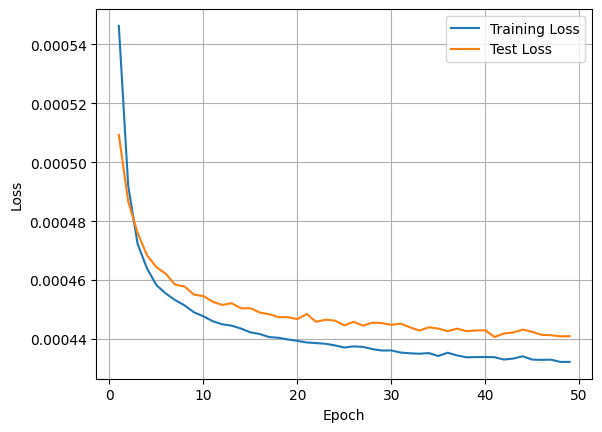

In [110]:
# Specify parameters
w_BCE = 1  # Weight for reconstruction error
w_KLD = 0.01  # Weight for KL-divergence error
latent_size = 2  # Dimension of latent space
num_epochs = 50
batch_size = 512
training_losses = np.zeros([num_epochs, 1])
test_losses = np.zeros([num_epochs, 1])

## Load data
# MNIST Dataset
train_dataset = datasets.MNIST(
    root=MNIST_DATA_DIR, train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root=MNIST_DATA_DIR, train=False, transform=transforms.ToTensor(), download=False
)

# Data Loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)


# Build model
x_dim = MNIST_IMAGE_SIZE**2

# Define 'layer_parameters' an array (or other data structure) containing paramters needed for network layers
layer_parameters = 1


vae = VAE(x_dim=x_dim, layer_parameters=layer_parameters, latent_size=latent_size)
optimizer = optim.Adam(vae.parameters())
vae.to(DEVICE)


# Perform training
start_time = time.time()
for epoch in range(1, num_epochs):
    train_loss = train(epoch, w_BCE, w_KLD, train_loader, vae, optimizer, loss_function)
    test_loss = test(w_BCE, w_KLD, test_loader, vae, loss_function)
    training_losses[epoch - 1] = train_loss
    test_losses[epoch - 1] = test_loss

end_time = time.time()
time_elapsed = end_time - start_time
minutes, seconds = divmod(time_elapsed, 60)
print("Time elapsed during training: %d minutes and %d seconds" % (minutes, seconds))

# Plot training and test losses
plt.plot(range(1, num_epochs), training_losses[:-1])
plt.plot(range(1, num_epochs), test_losses[:-1])
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Test Loss"])

print('Training complete, saving model.')
torch.save(vae.state_dict(), 'models/vae.pt')



# Visualize Results

Load MNIST test images and corresponding labels for visualizing results of trained model. 

In [111]:
for batch_idx, (test_images_batch, labels_batch) in enumerate(test_loader):
    if batch_idx == 0:
        test_images = test_images_batch.to(DEVICE)
        labels = labels_batch
    else:
        test_images = torch.cat((test_images, test_images_batch.to(DEVICE)), dim=0)
        labels = torch.cat((labels, labels_batch), dim=0)

num_test_samples = test_images.shape[0]

**Plot reconstructed image**

Load test image and compare with reconstructed image generated from trained VAE-model

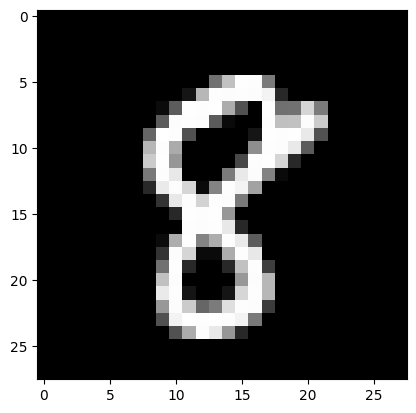

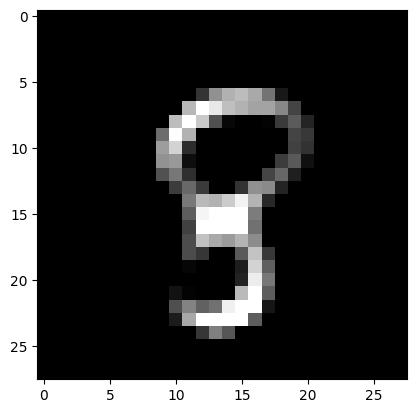

In [118]:
sample_index = np.random.randint(num_test_samples)

# Extract and plot a training image
x = test_images[sample_index, :, :, :]
img = x.cpu().reshape((28, 28))
plt.figure(1)
plt.imshow(img, cmap="gray", vmin=0, vmax=1)


# Generate and plot corresponding reconstructed image
mu, log_var = vae.encode(x.view(-1, MNIST_IMAGE_SIZE**2))
z = vae.sampling(mu, log_var)
x_recon = vae.decoder(z)
img_recon = x_recon.cpu().detach().numpy().reshape((28, 28))
plt.figure(2)
plt.imshow(img_recon, cmap="gray", vmin=0, vmax=1)


**Visualize latent space**

When latent_size = 2 then we can visualize latent space by using a 2D-scatter plot showing latents corresponding to each digit in a different colour.

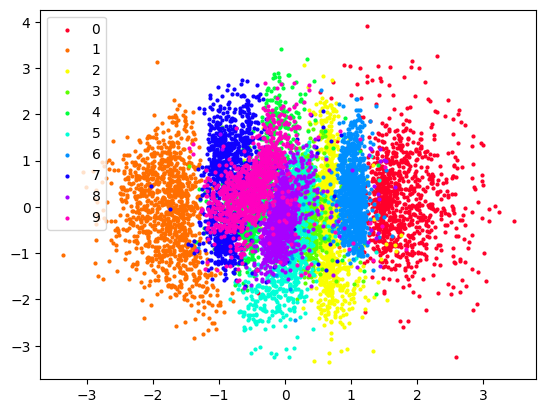

In [119]:
# Generate z for all images in test data
zs = np.zeros((num_test_samples, 2))
for i in range(num_test_samples):
    mu, log_var = vae.encode(test_images[i, :, :, :].view(-1, MNIST_IMAGE_SIZE**2))
    zs[i, :] = vae.sampling(mu, log_var).cpu().detach().numpy()


# Plot latent space
colors = plt.cm.gist_rainbow(np.linspace(0, 1, 10))
digit_labels = [str(i) for i in range(10)]

for digit in range(10):
    z_digit = zs[labels == digit]
    color = colors[digit, :]
    plt.scatter(z_digit[:, 0], z_digit[:, 1], color=color, marker="o", s=4)
plt.legend(digit_labels)


**Generate images by sampling from latent distribution**

We can sample points from latent space using e.g. a gaussian distribution with given mean and std and the feed them through decoder to generate new samples.

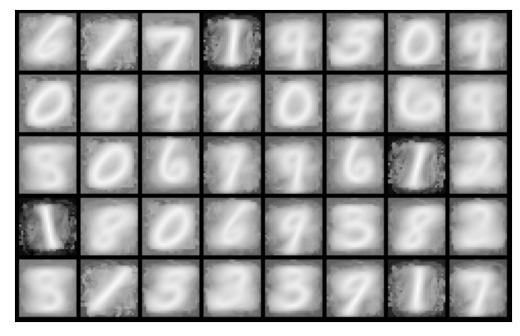

In [122]:
mu = [0, 0]
std = 1
num_samples = 40
os.makedirs(VAE_RESULT_DIR, exist_ok=True)
file_name = "samples"

with torch.no_grad():
    mu = torch.tensor(mu, device=DEVICE)
    z_rand = (torch.randn(num_samples, latent_size, device=DEVICE) * std) + mu
    sample = vae.decode(z_rand).to(DEVICE)
    grid_img = np.asarray(F_vision.to_pil_image(make_grid(sample.view(num_samples, 1, 28, 28), normalize=True).detach()))
    plt.imshow(grid_img)
    plt.xticks([], [])
    plt.yticks([], [])

Here comes code for interpolating between latents corresponding to two different digits.

([], [])

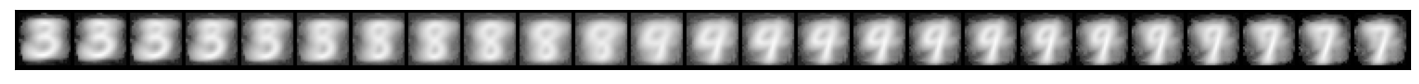

In [123]:
source_digit = 3
target_digit = 7
num_steps = 25

file_name_interpolation = f"interpolation_{source_digit}_to_{target_digit}"
# Extract latent variable for source image 
indices_source_digit = np.where(labels == source_digit)
random_indice_source_digit = np.random.choice(indices_source_digit[0])
x_source = test_images[random_indice_source_digit, :, :, :]
img_source = x_source.cpu().reshape((28, 28))
mu_source, log_var_source = vae.encode(x_source.view(-1, MNIST_IMAGE_SIZE**2))
z_source = vae.sampling(mu_source, log_var_source)

# Extract latent variable for target image 
indices_source_digit = np.where(labels == target_digit)
random_indice_source_digit = np.random.choice(indices_source_digit[0])
x_target = test_images[random_indice_source_digit, :, :, :]
img_target = x_target.cpu().reshape((28, 28))
mu_target, log_var_target = vae.encode(x_target.view(-1, MNIST_IMAGE_SIZE**2))
z_target = vae.sampling(mu_target, log_var_target)


# Perform linear interpolation between these two latents
alphas = np.linspace(0,1,num_steps)
z_interpols = torch.zeros((num_steps, latent_size), device=DEVICE)
for i in range(num_steps):
    alpha = alphas[i]
    z_interpol = (1-alpha)*z_source + alpha*z_target
    z_interpols[i,:] = z_interpol

# Pass interpolated latents through decoder to generate samples    
x_interpolation = vae.decode(z_interpols).to(DEVICE)
interpolation_grid_img = np.asarray(F_vision.to_pil_image(make_grid(x_interpolation.view(num_steps,1, 28, 28), nrow=num_steps, normalize=True).detach()))
fig, ax = plt.subplots(figsize=(18, 2), dpi=100)
ax.imshow(interpolation_grid_img)
plt.xticks([], [])
plt.yticks([], [])


# Discuss results


The task is now to use the VAE model and visualization tools to investigate the properties of the VAE model and how they are effected by changes to the model and loss function. The 3 main things to investigate are the effects of changing:
1. Model structure
2. Weighting of loss terms
3. Size of latent space

**Reconstruction quality and compression**
Investigate what effects reconstruction quality, i.e. how similar a reconstucted sample is to the original sample. Also investigate how this is related to compressions rate, i.e. the size of the latent space. 

I am not sure what the best way to display the different experiments in this notebook would be without signifcantly changing it. Wrap all code around a for loop where it is run with the desired configurations. I decide to not make these changes since the assignment is still exhaustive enough, but only discuss the outcomes of the different experiments and conclusions I have after playing around with it.

1. A CNN encoder/decoder architecture and a MLP model was compared. Both yielded good reconstructions when evaluating with a latent size set to 2.
2. As displayed in the lecture, one could weight the losses in different ways to obtain different results. If one only uses the reconstruction loss, we are likely to obtain a resulting latent space distribution similar to an autoencoder. I.e each class is mapped to a distinct region in latent space. This makes it difficult to interpolate between the different latent representations since there is a not of space that is beyond the data manifold.
3. A too large compression compromises the reconstruction but can improve the interpolation and generative tasks. This is for a similar reason as described above. If the latent space has many dimensions, there might be easier to find unique mappings from a latent space representation to a reconstructed image, but when one tried to interpolate between two latent representations one may move beyond the data manifold. 

**Properties of latent space**

Investigate what effects the properties of the latent space, i.e. how the generated VAE model can be used to generate new samples from the distribution of the original data. 

From the image above, showing a scatter plot of the latent space with 2 dimensions, I would argue that this is too few dimensions and possibly a too large weight on the KLD loss. One could sample around (0,0) and the decoder can yield several different images. In other words, we would like the latent space of one label to occupy a distinct region in space which has the most similar label as a neighbor in this space, possibly overlapping. Around the edges of the displayed scatter plot above, one can see for example that the "1" are furthest to the right and are somewhat overlapping with the "7" which is arguably the most similar digit, whereas the "0" is furthest to the left which is arguably the least similar. It is not clear why it seems to only separate the classes in one of the two available latent variables.

# VQ-VAE

In this part of the assignment, you will implement a version of the [Vector Quantized-VAE](https://arxiv.org/abs/1711.00937). 

## VQ-VAE loss
Let's begin by defining the loss function for the VQ-VAE.

The loss function is composed of three terms: 
- the reconstruction loss, forcing the output of the decoder to be close to the input,
- the VQ loss, pushing the quantized embedding vectors close to the output of the encoder, and
- the commitment loss, encouraging the encoder to commit to the same embedding vector for similar inputs.

The reconstruction loss is the mean squared error between the input and the output of the decoder. The VQ loss is the mean squared error between the output of the encoder and the output of the embedding layer. The commitment loss is the mean squared error between the output of the encoder and the output of the embedding layer, weighted by the commitment cost.

In [2]:
def vqvae_loss(
    x: torch.Tensor,
    x_recon: torch.Tensor,
    quantized_latents: torch.Tensor,
    latents: torch.Tensor,
    commit_loss_weight: int = 0.25,
):
    """Compute the VQ-VAE loss.

    Args:
        x: The original input image. Shape: (B, C, H, W)
        x_recon: The reconstructed image. Shape: (B, C, H, W)
        quantized_latents: The quatinzed latents. Shape: (B, C, H, W)
        latents: The encoded image. Shape: (B, C, H, W)
        commit_loss_weight: The weight of the commitment loss.

    Returns:
        loss: The total loss.
        recon_loss: The reconstruction loss.
        vq_loss: The VQ loss.
        commit_loss: The commitment loss.
    """
    # YOUR CODE HERE
    recon_loss = F.binary_cross_entropy_with_logits(x_recon, x)
    vq_loss = F.mse_loss(quantized_latents, latents)
    commit_loss = F.mse_loss(latents, quantized_latents)
    loss = recon_loss + vq_loss + commit_loss_weight*commit_loss
    
    return loss, recon_loss, vq_loss, commit_loss


In [79]:
def test_vqvae_loss(func):
    x = torch.randn(2, 3, 4, 4)
    x_recon = torch.randn(2, 3, 4, 4)
    quantized_latents = torch.randn(2, 3, 4, 4)
    latents = torch.randn(2, 3, 4, 4)
    loss, recon_loss, vq_loss, commit_loss = func(
        x, x_recon, quantized_latents, latents, commit_loss_weight=0.25
    )
    assert loss.shape == torch.Size([])
    assert recon_loss.shape == torch.Size([])
    assert vq_loss.shape == torch.Size([])
    assert commit_loss.shape == torch.Size([])
    assert loss == recon_loss + vq_loss + 0.25 * commit_loss

    # Check that the loss is correct
    recon_loss_np = np.mean((x_recon.numpy() - x.numpy()) ** 2)
    commit_loss_np = np.mean((quantized_latents.numpy() - latents.numpy()) ** 2)
    vq_loss_np = np.mean((quantized_latents.numpy() - latents.numpy()) ** 2)
    loss_np = recon_loss + vq_loss + 0.25 * commit_loss
    assert np.allclose(loss.numpy(), loss_np)
    
    print("Success!")

test_vqvae_loss(vqvae_loss)

Success!


## VQ-VAE model
While there are many ways of implementing the VQ-VAE, we will use the following architecture (inspired by the original paper):
- an encoder, which is a stack of 2D convolutional layers followed by two residual blocks,
- a convolution, projecting the output of the encoder to the embedding space,
- a vector quantizer, holding the codebook, and
- a decoder, which is a stack of two residual blocks followed by 2D transposed convolutional layers.

### Residual block
The residual block is a simple building block of the encoder and decoder. It consists of two 2D convolutional layers with ReLU activations, followed by a skip connection.

The model should do the following:
- apply a ReLU activation to the input,
- 2D convolution, with kernel size 3, stride 1, and padding 1, (no bias),
- ReLU activation,
- 2D convolution, with kernel size 1, stride 1, and padding 0, (no bias),

In [3]:
class ResBlock(nn.Module):
    """Residual block with 2 convolutional layers."""

    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        """Initialize the Residual block.

        Args:
            in_dim: Number of input channels.
            hidden_dim: Number of channels in the hidden layer.
            out_dim: Number of output channels.

        Attributes:
            block: A sequential container holding the layers of the block.
        """
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, hidden_dim, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=False)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.block(x)


In [81]:
def test_resblock():
    res_block = ResBlock(3, 4, 3)
    x = torch.randn(2, 3, 4, 4)
    y = res_block(x)
    assert y.shape == torch.Size([2, 3, 4, 4])
    print("Success!")

test_resblock()

Success!


### VQ-VAE encoder and decoder
Similar to the vanilla VAE, the encoder and decoder for VQ-VAE process the input -> latent -> output. 

The encoder should do the following:
- 2D convolution, with kernel size 4, stride 2, and padding 1, out_channels of hidden_dim // 2,
- ReLU activation,
- 2D convolution, with kernel size 4, stride 2, and padding 1, out_channels of hidden_dim,
- ReLU activation,
- 2D convolution, with kernel size 3, stride 1, and padding 1, out_channels of hidden_dim,
- two residual blocks,
- ReLU activation
  
The decoder should do the following:
- 2D convolution, with kernel size 3, stride 1, and padding 1, out_channels of hidden_dim,
- two residual blocks,
- ReLU activation,
- 2D transposed convolution, with kernel size 4, stride 2, and padding 1, out_channels of hidden_dim // 2,
- ReLU activation,
- 2D transposed convolution, with kernel size 4, stride 2, and padding 1, out_channels of in_channels

In [25]:
class VectorQuantizedVAEEncoder(nn.Module):
    """Encoder for VQ-VAE"""

    def __init__(self, input_dim: int, hidden_dim: int, residual_hidden_dim: int):
        """Encoder for VQ-VAE
        Args:
            input_dim (int): Number of input channels
            hidden_dim (int): Number of hidden channels
            residual_hidden_dim (int): Number of hidden channels in residual block

        Attributes:
            model (nn.Sequential): Encoder model
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim//2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim//2, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            ResBlock(hidden_dim, residual_hidden_dim, hidden_dim),
            ResBlock(hidden_dim, residual_hidden_dim, hidden_dim),
            nn.ReLU()
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method
        Args:
            x (torch.Tensor): Input tensor [B, C, H, W]
        Returns:
            torch.Tensor: Output tensor [B, C, H, W]
        """

        return self.model(x)


class VectorQuantizedVAEDecoder(nn.Module):
    """Decoder for VQ-VAE"""

    def __init__(
        self, input_dim: int, hidden_dim: int, residual_hidden_dim: int, output_dim: int
    ):
        """Decoder for VQ-VAE
        Args:
            input_dim (int): Number of input channels
            hidden_dim (int): Number of hidden channels
            residual_hidden_dim (int): Number of hidden channels in residual block
            output_dim (int): Number of output channels

        Attributes:
            model (nn.Sequential): Decoder model
        """

        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1, bias=False),
            ResBlock(hidden_dim, residual_hidden_dim, hidden_dim),
            ResBlock(hidden_dim, residual_hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, hidden_dim//2, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(hidden_dim//2, output_dim, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method
        Args:
            x (torch.Tensor): Input tensor [B, C, H, W]
        Returns:
            torch.Tensor: Output tensor [B, C, H, W]
        """
        return self.model(x)


In [26]:
def test_vqvae_encoder_decoder():
    encoder = VectorQuantizedVAEEncoder(3, 64, 32)
    decoder = VectorQuantizedVAEDecoder(64, 64, 32, 3)
    x = torch.randn(2, 3, 32, 32)
    y = decoder(encoder(x))
    assert y.shape == torch.Size([2, 3, 32, 32])
    print("Success!")

test_vqvae_encoder_decoder()

Success!


### VQ-VAE embedding
The embedding layer is used to replace the continuous output of the encoder with a discrete output. 

The model should do the following:
- Take the encoded image as input (assuming same channel size as the embedding layer)
- Find the closest embedding vector in the codebook for each feature in the image, independently
- Return:
  - the quantized embedding vectors with gradients from the embeddings, 
  - the quantized embedding vectors with gradients from the encoded input,
  - the perplexity of the codebook, and
  - the indices of the embedding vectors in the codebook.

The perplexity can be calculated as
$$
\exp\left(-\sum_{i=1}^N p_i \log{p_i}\right)
$$
where $p_i$ is the probability of the $i$ th embedding vector in the codebook, and $N$ is the number of embedding vectors in the codebook.

**What does the perplexity measure? Why is it useful?**

In this context, each embedding $e_i$ is used with a probability $p_i$. The perplexity is maximized when all $p_i$ are equal, i.e a uniform distribution and is minimized when all density is assigned to one embedding, i.e the model only uses one of the available embeddings. It is useful for this task to see whether the model learns to use a large proportion of the full codecook, which is probably desireable.

In [27]:
class VectorQuantizedEmbedding(nn.Module):
    """Vector Quantized Embedding layer"""

    def __init__(self, codebook_size: int, embedding_dim: int):
        """VQEmbedding layer
        Args:
            codebook_size (int): Number of embeddings
            embedding_dim (int): Dimension of each embedding

        Attributes:
            embedding (nn.Embedding): Embedding layer
        """
        super().__init__()
        self.codebook_size = codebook_size
        self.embedding = nn.Embedding(codebook_size, embedding_dim)
        self.embedding.weight.data.uniform_(-1.0 / codebook_size, 1.0 / codebook_size)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Forward method
        Takes in an encoded input tensor and returns the quantized latent tensor
        which is the closest embedding to the input (using L2 distance)

        Args:
            inputs (torch.Tensor): Encoded input tensor [B, C, H, W]
        Returns:
            latents_og_grad (torch.Tensor): Quantized latent tensor with gradients from codebook [B, C, H, W]
            latents_input_grad (torch.Tensor): Quantized latent tensor with gradients copied from input [B, C, H, W]
            perplexity (torch.Tensor): Perplexity of the codebook [1]
            encoding_indices (torch.Tensor): Index of the closest embedding for each input [B, H, W]
        """
        

        # Permute the input tensor to [B, H, W, C]
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten the input tensor to [BHW, C]
        flat_input = inputs.view(-1, input_shape[-1]).unsqueeze(dim=1).repeat([1,self.codebook_size, 1])

        encoding_indices = torch.norm(flat_input - self.embedding(torch.tensor([idx for idx in range(self.codebook_size)], dtype=int).to('cuda')).unsqueeze(dim=0), dim=2).argmin(dim=1)
        # raise NotImplementedError()
        latents_og_grad = self.embedding(encoding_indices).view(input_shape)
    
        # Compute the quantized latent tensor with input gradients
        latents_input_grad = inputs + (latents_og_grad - inputs).detach()

        # Permute the quantized latent tensor [B, H, W, C] -> [B, C, H, W]
        latents_og_grad = latents_og_grad.permute(0, 3, 1, 2).contiguous()
        latents_input_grad = latents_input_grad.permute(0, 3, 1, 2).contiguous()

        probs = torch.bincount(encoding_indices)/torch.sum(torch.bincount(encoding_indices))
        eps = 1e-10
        perplexity = torch.exp(-torch.sum(torch.tensor([p*torch.log(p+eps) for p in probs])))
        # Encoding indices [BHW] -> [B, H, W] 
        encoding_indices = encoding_indices.view(input_shape[:-1]).contiguous()
        return (
            latents_og_grad,
            latents_input_grad,
            perplexity,
            encoding_indices,
        )


In [86]:
def test_vqvae_codebook():
    codebook = VectorQuantizedEmbedding(10, 64)
    x = torch.randn(2, 64, 32, 32, requires_grad=True)
    y, latents_input_grad, perplexity, encoding_indices = codebook(x)
    assert y.shape == torch.Size([2, 64, 32, 32])
    assert latents_input_grad.shape == torch.Size([2, 64, 32, 32])
    assert perplexity.shape == torch.Size([])
    assert encoding_indices.shape == torch.Size([2, 32, 32])
    assert encoding_indices.dtype == torch.int64

    print("Success!")

test_vqvae_codebook()

Success!


### VQ-VAE full model
Now that we have defined the encoder, decoder, and embedding layer, we can define the full VQ-VAE model. The only thing we need to add is a 2D convolutional layer to project the output of the encoder to the embedding space (as they may have different channel sizes).

In [28]:
class VectorQuantizedVAE(nn.Module):
    """VQ-VAE"""

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        codebook_size: int,
        embedding_dim: int,
        residual_hidden_dim: int,
    ):
        """VQ-VAE
        Args:
            input_dim (int): Number of input channels
            hidden_dim (int): Number of hidden channels
            codebook_size (int): Number of codebook entries
            embedding_dim (int): Number of embedding dimensions
            residual_hidden_dim (int): Number of hidden channels in residual block

        Attributes:
            encoder (VectorQuantizedVAEEncoder): Encoder
            pre_vq_conv (nn.Conv2d): Convolutional layer before VQ layer
            codebook (VectorQuantizedEmbedding): VQ layer
            decoder (VectorQuantizedVAEDecoder): Decoder
        """

        super().__init__()
        self.encoder = VectorQuantizedVAEEncoder(input_dim, hidden_dim, residual_hidden_dim)
        self.decoder = VectorQuantizedVAEDecoder(embedding_dim, hidden_dim, residual_hidden_dim, input_dim)
        self.codebook = VectorQuantizedEmbedding(codebook_size, embedding_dim)
        self.pre_vq_conv = nn.Conv2d(hidden_dim, embedding_dim, kernel_size=3, stride=1, padding=1)
        self.apply(vq_vae_utils.weights_init)

    def encode(self, x):
        """Encode method, same as foward method but without the decoder
        Args:
            x (torch.Tensor): Input tensor [B, C, H, W]

        Returns:
            latents_og_grad (torch.Tensor): Quantized latents from VQ layer [B, C, H, W]
            latents_input_grad (torch.Tensor): Quantized latents from VQ layer [B, C, H, W]
            perplexity (torch.Tensor): Perplexity of VQ layer [1]
            encoding_idxs (torch.Tensor): Index of the closest embedding for each input [B, H, W]
        """
        latents_og_grad, latents_input_grad, perplexity, encoding_indices = self.codebook(self.pre_vq_conv(self.encoder(x)))

        return latents_og_grad, latents_input_grad, perplexity, encoding_indices

    def forward(self, x):
        """Forward method
        Args:
            x (torch.Tensor): Input tensor [B, C, H, W]

        Returns:
            x_recon (torch.Tensor): Reconstructed input tensor [B, C, H, W]
            latents_og_grad (torch.Tensor): Quantized latents from VQ layer [B, C, H, W]
            z (torch.Tensor): Latents from encoder [B, C, H, W]
            perplexity (torch.Tensor): Perplexity of VQ layer [1]
        """
        z = self.pre_vq_conv(self.encoder(x))
        latents_og_grad, latents_input_grad, perplexity, encoding_indices = self.codebook(z)
        x_recon = self.decoder(latents_input_grad)
        return x_recon, latents_og_grad, z, perplexity

In [7]:
def test_vqvae():
    vqvae = VectorQuantizedVAE(3, 64, 512, 64, 32)
    x = torch.randn(2, 3, 28, 28, requires_grad=True)
    y, latents_input_grad, z, perplexity = vqvae(x)
    assert y.shape == torch.Size([2, 3, 28, 28])
    assert latents_input_grad.shape == torch.Size([2, 64, 7, 7])
    assert z.shape == torch.Size([2, 64, 7, 7])
    assert perplexity.shape == torch.Size([])
    print("Success!")

test_vqvae()

Success!


## Training the VQ-VAE

We give you a train and test loop for the VQ-VAE. 

In [8]:
def train_vq_vae(data_loader, model, optimizer, device, beta):
    out = defaultdict(list)
    for images, _ in data_loader:
        images = images.to(device)

        optimizer.zero_grad()
        x_recon, latents_og_grad, encoded_input, perplexity = model(images)

        loss, recon_loss, vq_loss, commit_loss = vqvae_loss(
            images, x_recon, latents_og_grad, encoded_input, beta
        )
        loss.backward()

        optimizer.step()
        out["loss"].append(loss.item())
        out["recon_loss"].append(recon_loss.item())
        out["vq_loss"].append(vq_loss.item())
        out["commit_loss"].append(commit_loss.item())
        out["perplexity"].append(perplexity.item())

    return out


def test_vq_vae(data_loader, model, device, beta=0.25):
    out = defaultdict(list)
    with torch.no_grad():
        loss_recons, loss_vq = 0.0, 0.0
        for images, _ in data_loader:
            images = images.to(device)
            x_recon, latents_og_grad, encoded_input, perplexity = model(images)
            loss, recon_loss, vq_loss, commit_loss = vqvae_loss(
                images, x_recon, latents_og_grad, encoded_input, beta
            )

        recon_loss /= len(data_loader)
        vq_loss /= len(data_loader)

    out["recon_loss"].append(recon_loss.item())
    out["vq_loss"].append(vq_loss.item())
    return out


Test images


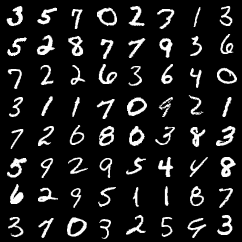

In [30]:
batch_size = 1024
num_workers = 2
num_epochs = 25
learning_rate = 3e-4
hidden_dim = 64
residual_hidden_dim = 16
embedding_dim = 16
codebook_size = 8

beta = 0.25


transform = transforms.Compose(
    [transforms.ToTensor()]
)
# Define the train & test datasets
train_dataset = datasets.MNIST(
    MNIST_DATA_DIR, train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(MNIST_DATA_DIR, train=False, transform=transform)
valid_dataset = test_dataset

num_channels = 1

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True,
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)


os.makedirs(VQ_VAE_RESULT_DIR, exist_ok=True)
fixed_images, _ = next(iter(test_loader))
fixed_grid = make_grid(fixed_images, nrow=8, value_range=(0, 1))
save_image(fixed_grid, f"{VQ_VAE_RESULT_DIR}/fixed_grid.png")
fixed_grid_img = tensor_to_pil_image(fixed_grid)
print("Test images")
display(fixed_grid_img)


Reconstructed images, epoch 0


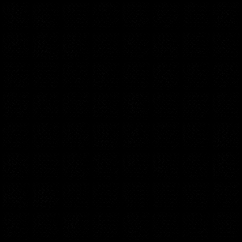

In [31]:
model = VectorQuantizedVAE(
    num_channels, hidden_dim, codebook_size, embedding_dim, residual_hidden_dim
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Generate the samples first once
reconstruction = vq_vae_utils.generate_samples(fixed_images, model, DEVICE)
grid = make_grid(reconstruction.cpu(), nrow=8, value_range=(0, 1), normalize=True)
save_image(grid, f"{VQ_VAE_RESULT_DIR}/reconstruction_0.png")
grid_img = tensor_to_pil_image(grid)
print("Reconstructed images, epoch 0")
display(grid_img)


 16%|█▌        | 4/25 [00:10<00:56,  2.67s/it]

Reconstructed images, epoch 5


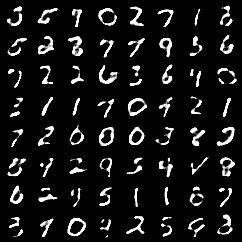

 36%|███▌      | 9/25 [00:24<00:43,  2.74s/it]

Reconstructed images, epoch 10


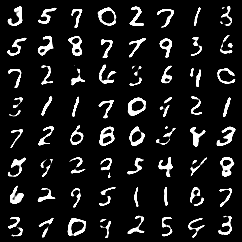

 56%|█████▌    | 14/25 [00:38<00:30,  2.81s/it]

Reconstructed images, epoch 15


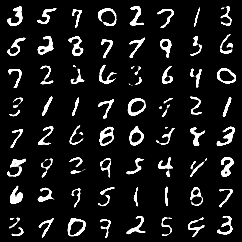

 76%|███████▌  | 19/25 [00:52<00:17,  2.91s/it]

Reconstructed images, epoch 20


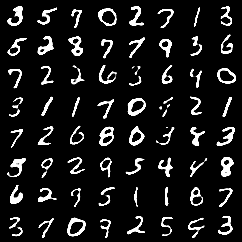

 96%|█████████▌| 24/25 [01:07<00:02,  2.99s/it]

Reconstructed images, epoch 25


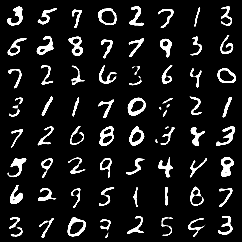

100%|██████████| 25/25 [01:10<00:00,  2.84s/it]


In [32]:
best_loss = -1.0
save_freq = 5
vq_vae_train_stats = defaultdict(list)
for epoch in tqdm(range(num_epochs)):
    new_train_stats = train_vq_vae(train_loader, model, optimizer, DEVICE, beta)
    for k, v in new_train_stats.items():
        vq_vae_train_stats[k].extend(v)

    recon_loss_val, vq_loss_val = test_vq_vae(valid_loader, model, DEVICE, beta)


    if (epoch == 0) or (recon_loss_val < best_loss):
        best_loss = recon_loss_val
        with open("{0}/best.pt".format(VQ_VAE_RESULT_DIR), "wb") as f:
            torch.save(model.state_dict(), f)

    if (epoch + 1) % save_freq == 0:
        reconstruction = vq_vae_utils.generate_samples(fixed_images, model, DEVICE)
        grid = make_grid(reconstruction.cpu(), nrow=8, value_range=(0, 1), normalize=True)
        save_image(grid, "{0}/reconstruction_{1}.png".format(VQ_VAE_RESULT_DIR, epoch + 1))
        grid_img = tensor_to_pil_image(grid)
        print(f"Reconstructed images, epoch {epoch+1}")
        display(grid_img)
        with open("{0}/model_{1}.pt".format(VQ_VAE_RESULT_DIR, epoch + 1), "wb") as f:
            torch.save(model.state_dict(), f)

with open("{0}/last.pt".format(VQ_VAE_RESULT_DIR), "wb") as f:
    torch.save(model.state_dict(), f)


## VQ-VAE visualization

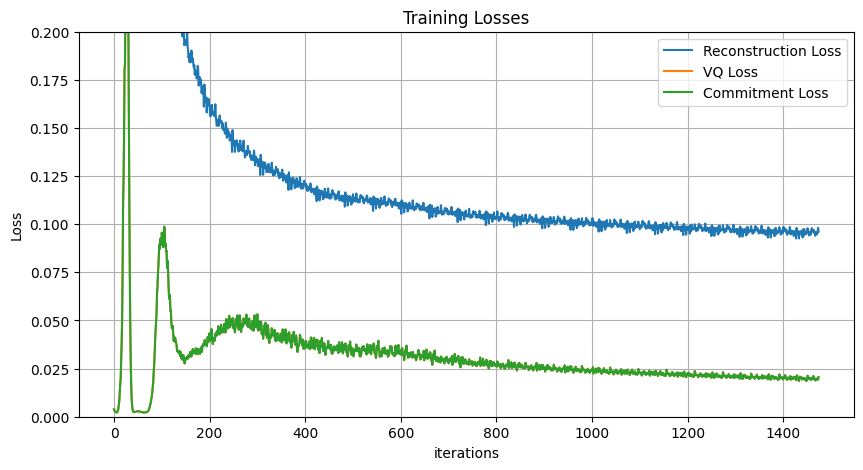

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Training Losses")

plt.plot(vq_vae_train_stats["recon_loss"], label="Reconstruction Loss")
plt.plot(vq_vae_train_stats["vq_loss"], label="VQ Loss")
plt.plot(vq_vae_train_stats["commit_loss"], label="Commitment Loss")
# set y range to 0 to 1
plt.ylim(0, 0.2)
# set log scale
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid("on")
plt.show()


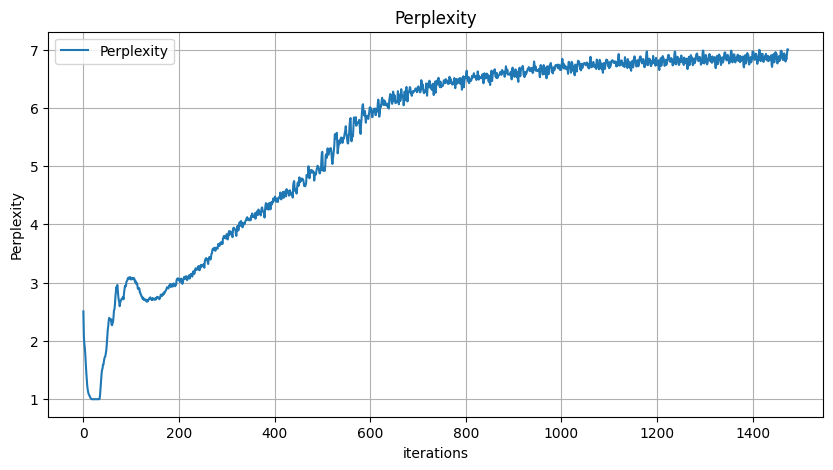

In [34]:
# plot perplexity
plt.figure(figsize=(10, 5))
plt.title("Perplexity")
plt.plot(vq_vae_train_stats["perplexity"], label="Perplexity")
plt.xlabel("iterations")
plt.ylabel("Perplexity")
plt.legend()
plt.grid("on")
plt.show()


Uniformly sampled images


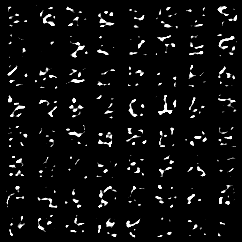

In [77]:
def generate_samples(model: nn.Module, indices: torch.tensor) -> torch.tensor:
    """Generate samples from the model
    Args:
        model (nn.Module): Model
        indices (torch.tensor): Indices
    Returns:
        samples (torch.tensor): Samples
    """
    model.eval()
    embeddings = model.codebook.embedding.weight.data
    num_embeddings, embedding_dim = embeddings.shape
    H, W = 7, 7

    assert (
        indices.view(-1).shape[0] % (H * W) == 0
    ), "Number of indices must be divisible by H*W"

    # draw H*W samples from the codebook
    latents = (
        embeddings[indices.flatten()].view(-1, H, W, embedding_dim).permute(0, 3, 1, 2)
    )
    with torch.no_grad():
        samples = model.decoder(latents)
    return samples


def draw_samples_uniformly(model: nn.Module, n_samples: int) -> torch.tensor:
    """Draw samples from the model
    Args:
        model (nn.Module): Model
        n_samples (int): Number of samples
    Returns:
        samples (torch.tensor): Samples
    """
    model.eval()
    embeddings = model.codebook.embedding.weight.data
    num_embeddings, embedding_dim = embeddings.shape
    H, W = 7, 7
    # draw H*W samples from the codebook
    indices = torch.randint(0, num_embeddings, (H * W * n_samples,))
    return generate_samples(model, indices)


samples = draw_samples_uniformly(model, 64)
samples_grid = make_grid(samples.cpu(), nrow=8, value_range=(0, 1))
save_image(samples_grid, f"{VQ_VAE_RESULT_DIR}/uniform_samples.png")

samples_grid_img = tensor_to_pil_image(samples_grid)
print("Uniformly sampled images")
display(samples_grid_img)

Although VQ-VAE has good reconstruction, these samples don't look to nice. Why is that?

In each pixel, an embedding from the codebook is selected from a uniform random distribution. This will most likely create a latent representation of an image which has no corresponding "real" image. Another way to look at it is that during training and reconstruction, each input image is mapped via the encoder to a latent data manifold which is projected to the embeddings. The decoder learns a mapping from this manifold to an image in input space. When we sample randomly in the latent space we are probably sampling outside of the data manifold where the decoder has possibly not learnt an appropriate mapping, resulting in images which do not look like handwritten digits.

We can have a look at what encodings are used where in the image. We can do this by plotting the indices of the embedding vectors in the codebook.

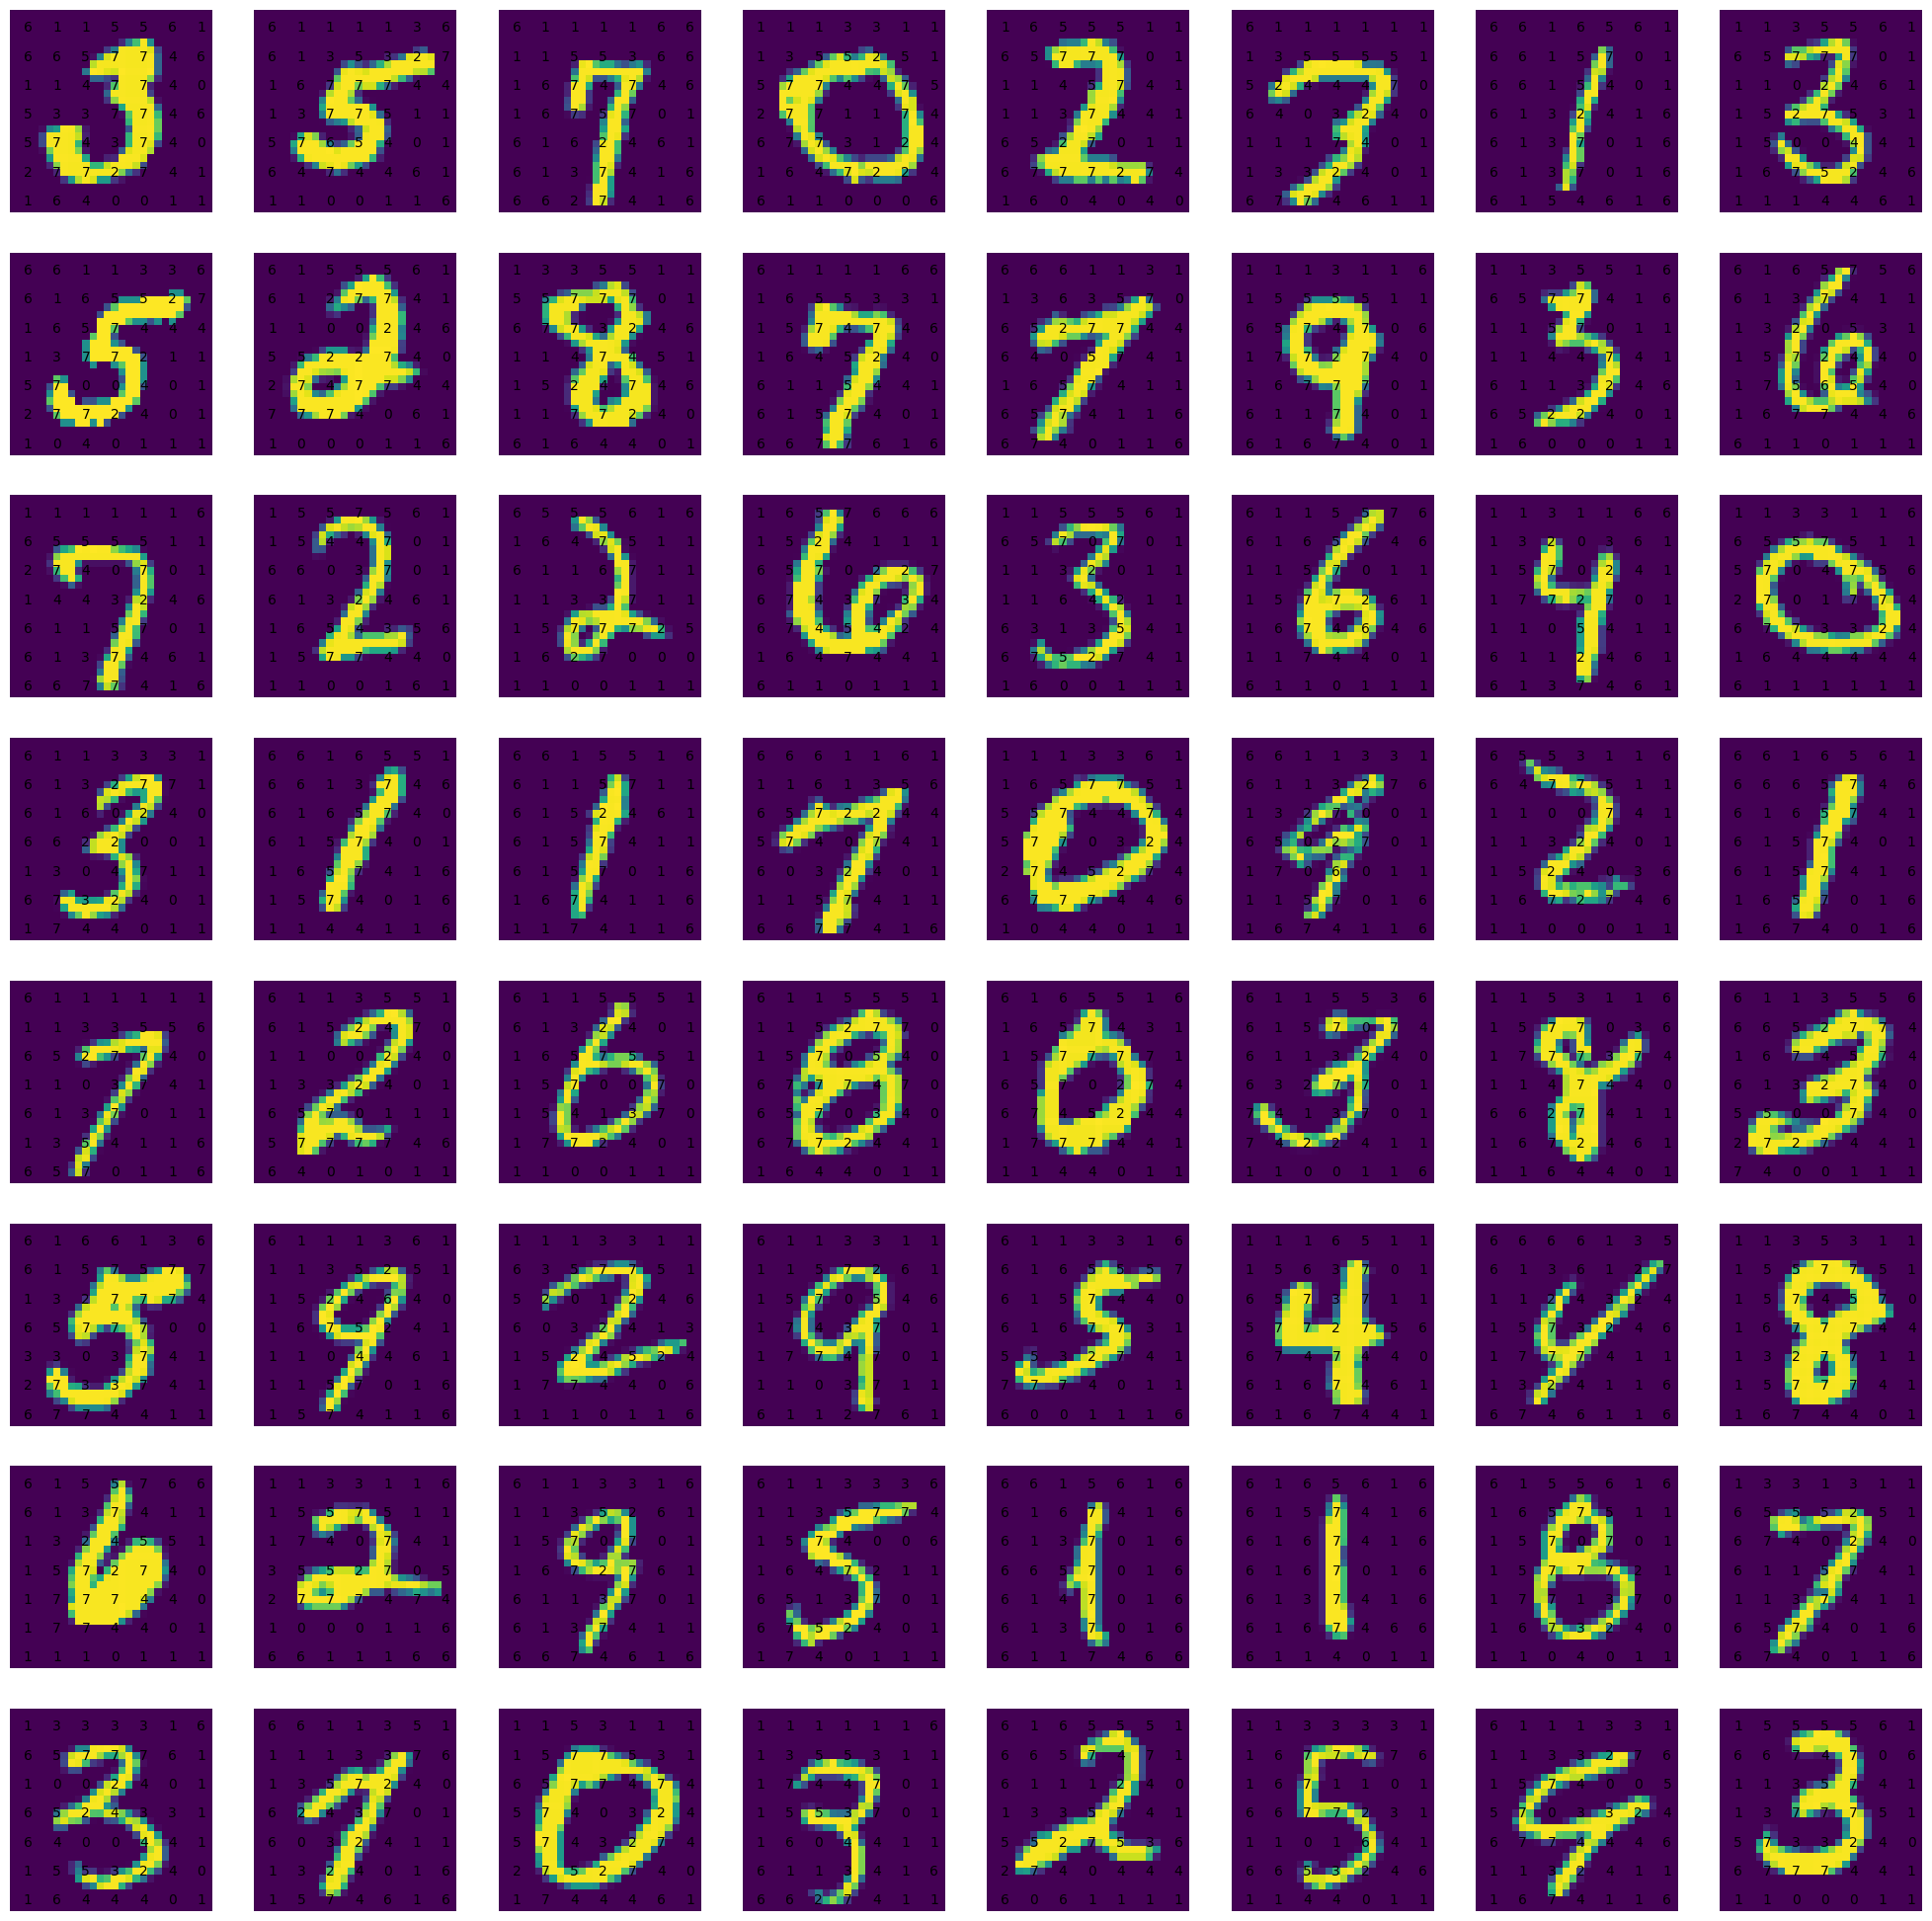

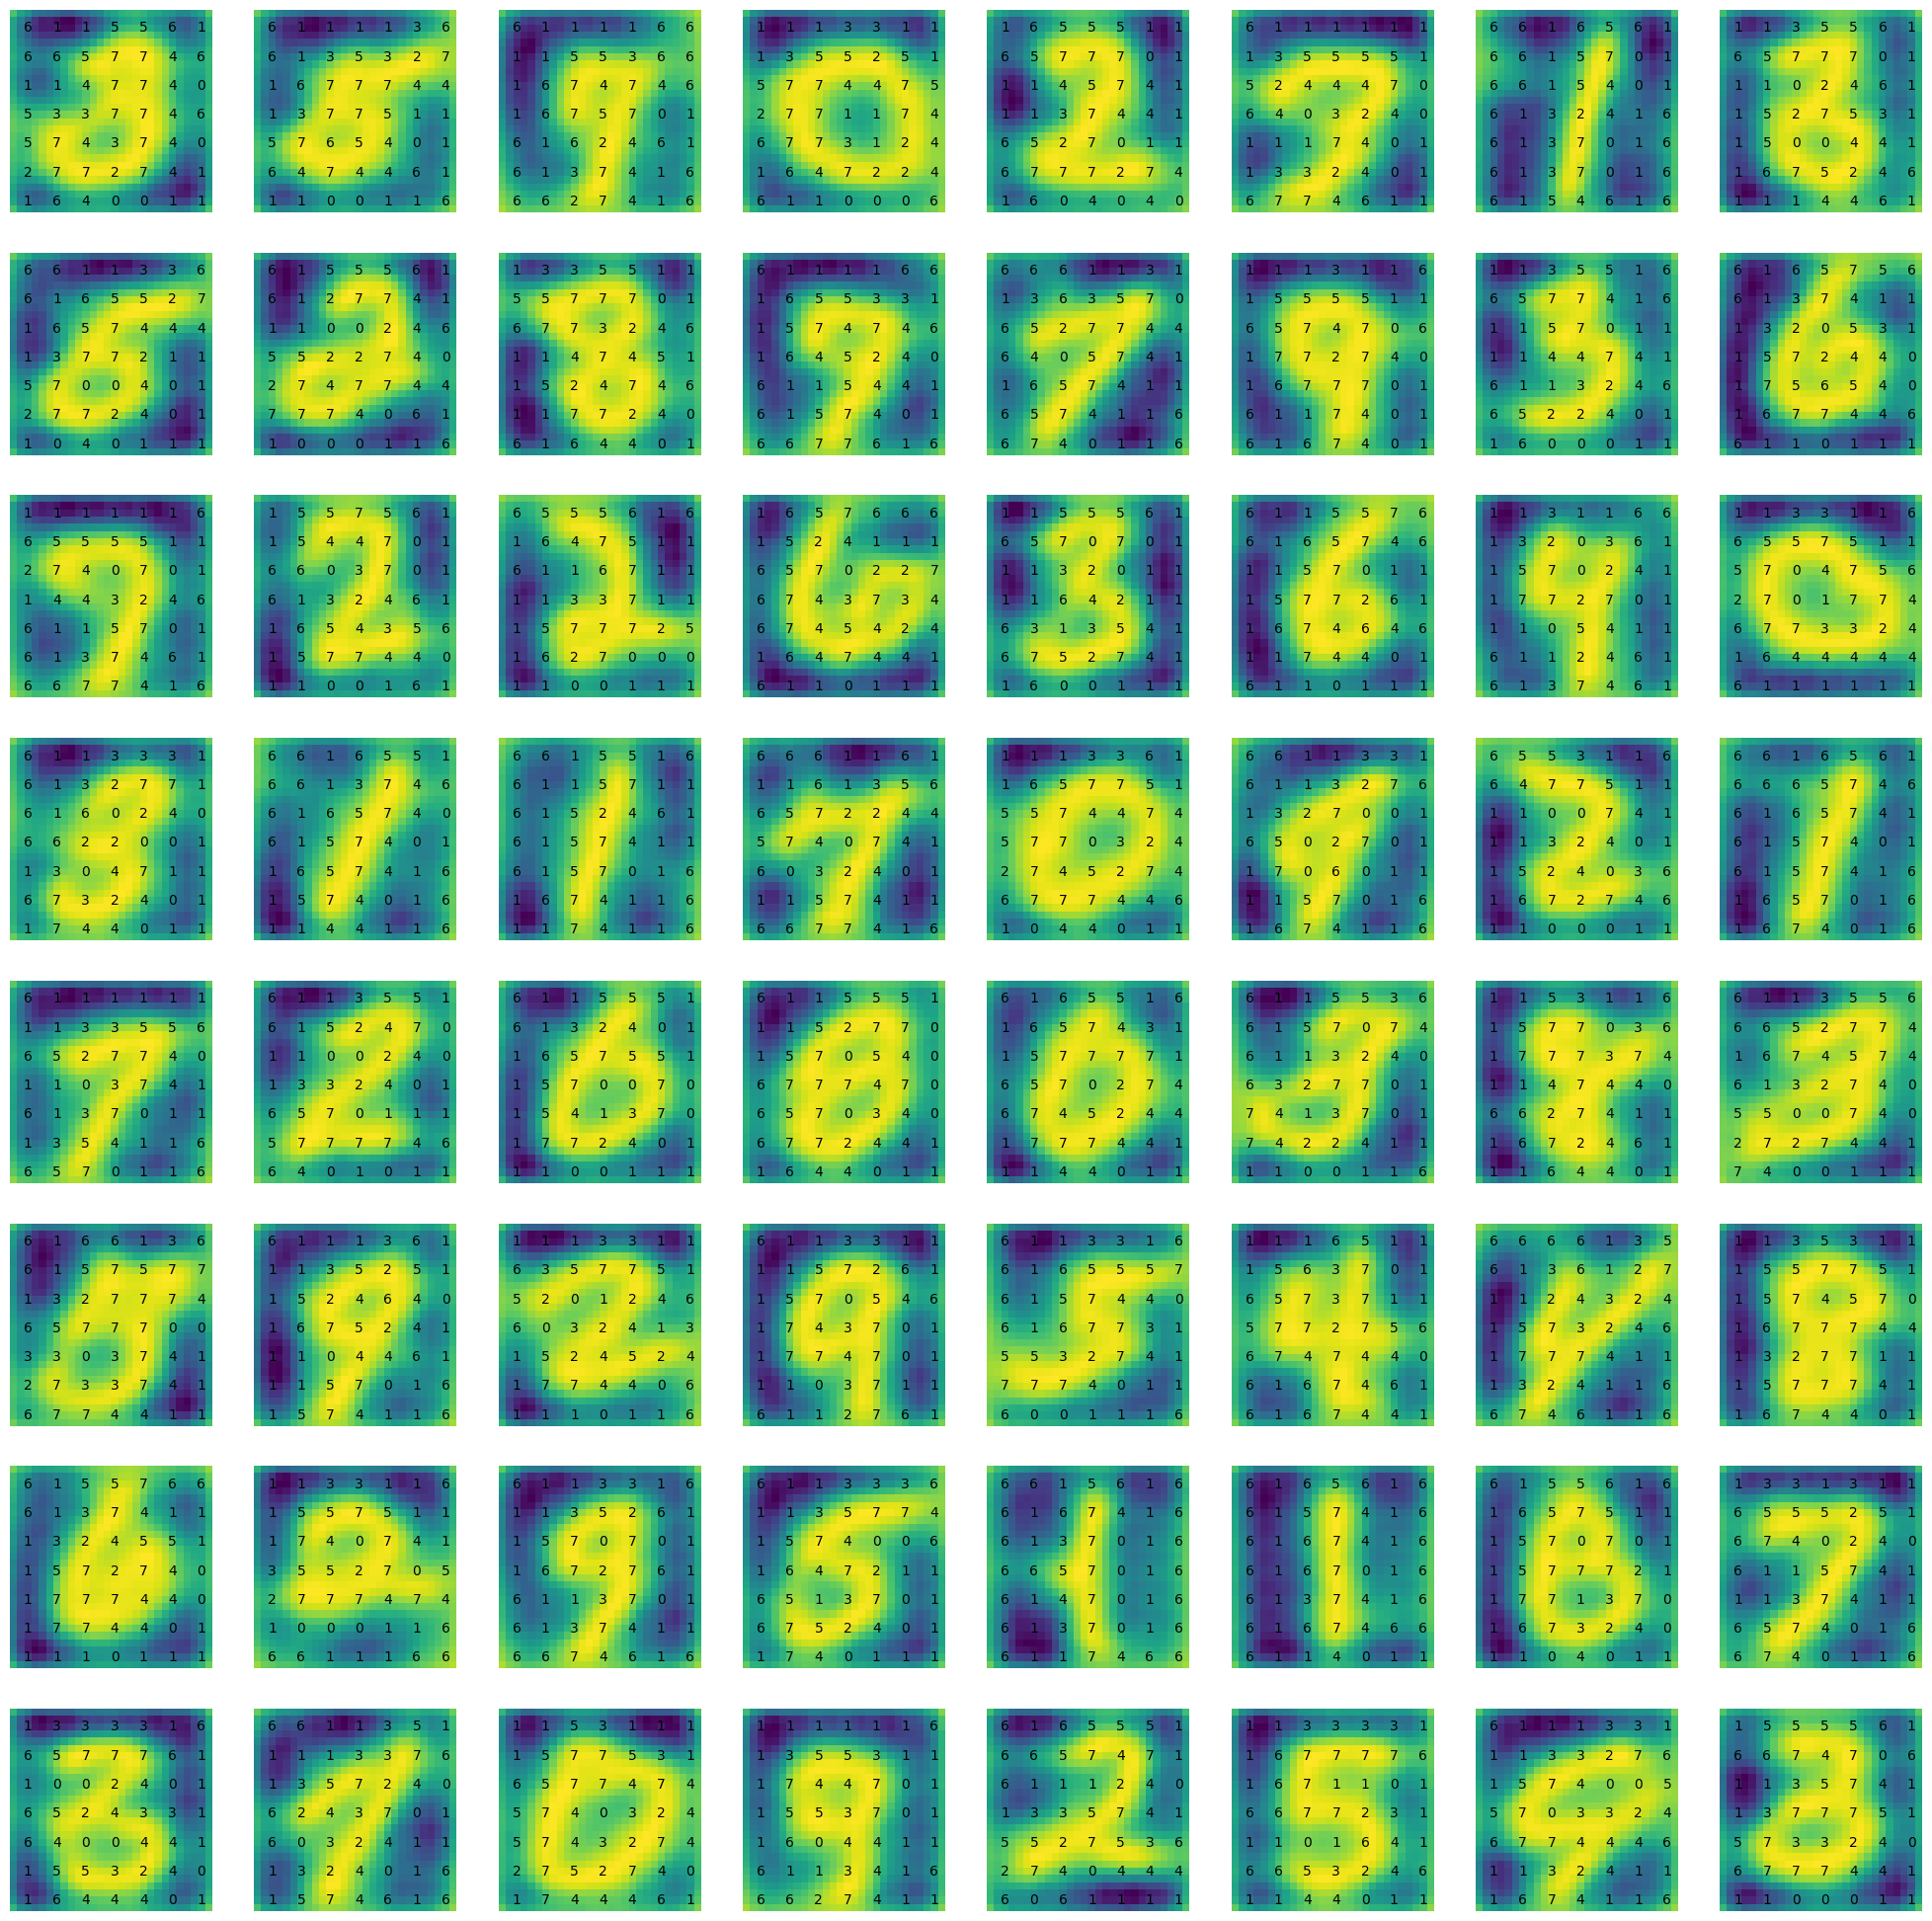

In [38]:
def overlay_encoding_idxs(
    images: torch.tensor,
    encoding_idxs: torch.tensor,
    img_per_row: int = 8,
    figsize: tuple = (25, 25),
):
    """
    Function for drawing the images and overlay their encoding indices
    """
    num_images, c, h, w = images.shape
    _, enc_h, enc_w = encoding_idxs.shape

    fig = plt.figure(figsize=figsize)

    for i, image in enumerate(images):
        # draw a subplot for each image in grid shape
        ax = fig.add_subplot(img_per_row, img_per_row, i + 1)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.axis("off")
        # Add the text
        jump_x = w / (2.0 * 7)
        jump_y = h / (2.0 * 7)
        x_positions = np.linspace(start=0, stop=w, num=enc_w, endpoint=False)
        y_positions = np.linspace(start=0, stop=h, num=enc_h, endpoint=False)
        for y_index, y in enumerate(y_positions):
            for x_index, x in enumerate(x_positions):
                label = encoding_idxs[i, y_index, x_index].cpu().numpy()
                text_x = x + jump_x
                text_y = y + jump_y
                ax.text(text_x, text_y, label, color="black", ha="center", va="center")


_, _, _, encoding_idxs = model.encode(fixed_images.to(DEVICE))
og_samples = generate_samples(model, encoding_idxs)
overlay_encoding_idxs(fixed_images.to(DEVICE), encoding_idxs)
overlay_encoding_idxs(og_samples.to(DEVICE), encoding_idxs)


Now you can change some indices to see what happens to the image.

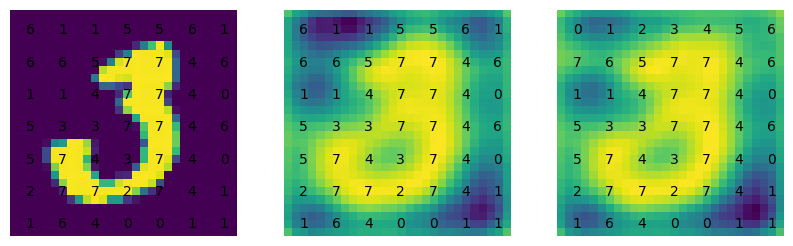

In [72]:
image_idx = 0

# get the encoding indices for the image
selected_encoding_idxs = encoding_idxs[image_idx].unsqueeze(0)
# get the image
image = fixed_images[image_idx].unsqueeze(0)

custom_encoding_idxs = selected_encoding_idxs.clone()
# change the encoding indices

custom_encoding_idxs[0, 0, 0] = 0
custom_encoding_idxs[0, 0, 1] = 1
custom_encoding_idxs[0, 0, 2] = 2
custom_encoding_idxs[0, 0, 3] = 3
custom_encoding_idxs[0, 0, 4] = 4
custom_encoding_idxs[0, 0, 5] = 5
custom_encoding_idxs[0, 0, 6] = 6
custom_encoding_idxs[0, 1, 0] = 7

# generate samples
og_samples = generate_samples(model, selected_encoding_idxs).cpu()
custom_samples = generate_samples(model, custom_encoding_idxs).cpu()
# concatenate the images
samples = torch.cat([image, og_samples, custom_samples], dim=0).cpu()
# concatenate the encoding indices
selected_encoding_idxs = torch.cat(
    [selected_encoding_idxs, selected_encoding_idxs, custom_encoding_idxs], dim=0
)
overlay_encoding_idxs(samples, selected_encoding_idxs, img_per_row=3, figsize=(10, 10))


Can you figure out which indices are used for which parts of the image? Set the identified foreground and background indices below for a surprise!

Feel free to play around if you can create something cool.

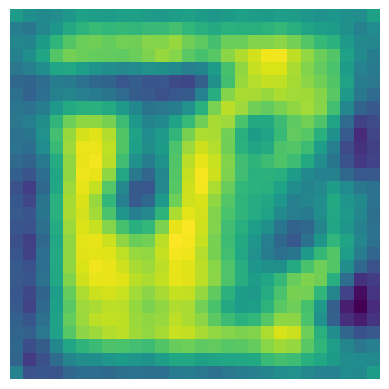

In [73]:
# change the encoding indices
foreground_idx = 7
background_idx = 0


custom_encoding_idxs = (
    torch.tensor(
        [
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
        ]
    )
    .cuda()
    .unsqueeze(0)
)

# TK
custom_encoding_idxs[0, :, :] = 7
custom_encoding_idxs[0, 1, 1] = 0
custom_encoding_idxs[0, 1, 2] = 0
custom_encoding_idxs[0, 1, 3] = 0
custom_encoding_idxs[0, 2, 2] = 0
custom_encoding_idxs[0, 3, 2] = 0
custom_encoding_idxs[0, 2, 4] = 0
custom_encoding_idxs[0, 3, 4] = 0
custom_encoding_idxs[0, 4, 4] = 0
custom_encoding_idxs[0, 5, 4] = 0
custom_encoding_idxs[0, 3, 5] = 0
custom_encoding_idxs[0, 2, 6] = 0
custom_encoding_idxs[0, 4, 5] = 0
custom_encoding_idxs[0, 5, 6] = 0

custom_samples = generate_samples(model, custom_encoding_idxs).cpu()

plt.imshow(custom_samples[0].permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()


## PixelCNN prior

To improve the sample quality, we can learn a prior distribution over the latent space, and use this prior to sample from the latent space. We will use a PixelCNN prior, which is a conditional autoregressive model. 

For your convenience, we have provided a PixelCNN prior implementation. It will be trained using your last VQ-VAE checkpoint.

In [74]:
def train_pixelcnn(data_loader, model, prior, optimizer, device):
    for images, labels in data_loader:
        with torch.no_grad():
            images = images.to(device)
            z = model.encoder(images)
            z = model.pre_vq_conv(z)
            _, _, _, latent_idx = model.codebook(z)
            latent_idx = latent_idx.detach()

        labels = labels.to(device)

        logits = prior(latent_idx, labels)
        logits = logits.permute(0, 2, 3, 1).contiguous()

        optimizer.zero_grad()
        loss = F.cross_entropy(
            logits.view(-1, model.codebook.embedding.weight.data.shape[0]),
            latent_idx.view(-1),
        )
        loss.backward()

        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

        optimizer.step()


def test_pixelcnn(data_loader, model, prior, device):
    with torch.no_grad():
        loss = 0.0
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            z = model.encoder(images)
            z = model.pre_vq_conv(z)
            _, _, _, latent_idx = model.codebook(z)
            latent_idx = latent_idx.detach()
            logits = prior(latent_idx, labels)
            logits = logits.permute(0, 2, 3, 1).contiguous()
            loss += F.cross_entropy(
                logits.view(-1, model.codebook.embedding.weight.data.shape[0]),
                latent_idx.view(-1),
            )

        loss /= len(data_loader)

    return loss.item()


n_layers_pixelcnn = 12
lr = 1e-3
num_epochs = 50
model = VectorQuantizedVAE(
    num_channels, hidden_dim, codebook_size, embedding_dim, residual_hidden_dim
).to(DEVICE)

with open("{0}/last.pt".format(VQ_VAE_RESULT_DIR), "rb") as f:
    model.load_state_dict(torch.load(f))

model.eval()


VectorQuantizedVAE(
  (encoder): VectorQuantizedVAEEncoder(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (2): ReLU()
          (3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
      )
      (6): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (2): ReLU()
          (3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
      )
      (7): ReLU()
    )
  )
  (decoder): VectorQuantizedVAEDecoder(
    (model): Sequ

In [75]:
prior = GatedPixelCNN(
    codebook_size,
    embedding_dim,
    n_layers_pixelcnn,
    n_classes=len(train_dataset.targets),
    conditional=True,
).to(DEVICE)
optimizer = torch.optim.Adam(prior.parameters(), lr=lr)


best_loss = -1.0
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    train_pixelcnn(train_loader, model, prior, optimizer, DEVICE)
    loss = test_pixelcnn(valid_loader, model, prior, DEVICE)
    pbar.set_description("Val loss: {0}".format(loss))

    if (epoch == 0) or (loss < best_loss):
        best_loss = loss
        with open(f"{VQ_VAE_RESULT_DIR}/pixel_cnn.pt", "wb") as f:
            torch.save(prior.state_dict(), f)


Val loss: 0.7272622585296631: 100%|██████████| 50/50 [04:32<00:00,  5.44s/it]


Now we can use the PixelCNN prior to sample from the latent space. We can do this by sampling from the prior, and then using the VQ-VAE to decode the samples. Note that we trained a class conditional PixelCNN prior, so we need to provide the class label to the prior.

Conditionally sampled images, class 0


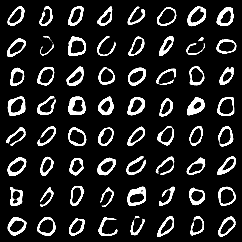

Conditionally sampled images, class 1


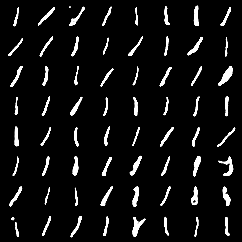

Conditionally sampled images, class 2


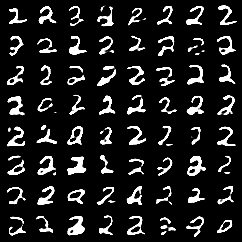

Conditionally sampled images, class 3


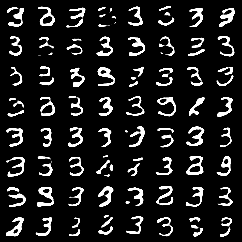

Conditionally sampled images, class 4


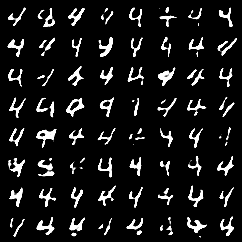

Conditionally sampled images, class 5


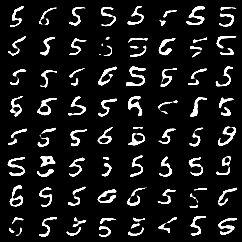

Conditionally sampled images, class 6


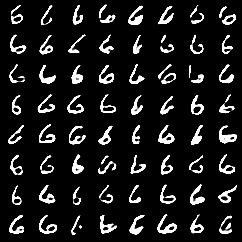

Conditionally sampled images, class 7


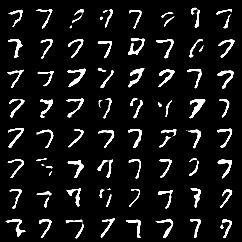

Conditionally sampled images, class 8


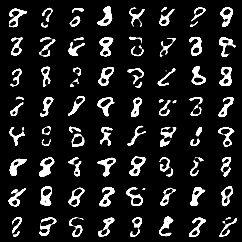

Conditionally sampled images, class 9


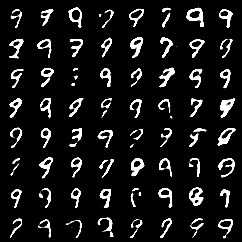

In [76]:
def draw_samples_with_prior(
    model: nn.Module, prior: nn.Module, n_samples: int, label: int
) -> torch.tensor:
    """Draw samples from the model
    Args:
        model (nn.Module): Model
        n_samples (int): Number of samples
    Returns:
        samples (torch.tensor): Samples
    """
    model.eval()
    embeddings = model.codebook.embedding.weight.data
    _, embedding_dim = embeddings.shape
    H, W = 7, 7
    # draw H*W samples from the codebook
    indices = prior.generate(label, shape=(H, W), batch_size=n_samples)
    latents = (
        embeddings[indices].view(n_samples, H, W, embedding_dim).permute(0, 3, 1, 2)
    )
    with torch.no_grad():
        samples = model.decoder(latents)
    return samples


prior = GatedPixelCNN(
    codebook_size,
    embedding_dim,
    n_layers_pixelcnn,
    n_classes=len(train_dataset.targets),
).to(DEVICE)
with open(f"{VQ_VAE_RESULT_DIR}/pixel_cnn.pt", "rb") as f:
    prior.load_state_dict(torch.load(f))

for i in range(10):
    samples = draw_samples_with_prior(
        model, prior, 64, torch.tensor([i], device=DEVICE)
    )
    samples_grid = make_grid(samples.cpu(), nrow=8, value_range=(0, 1))
    save_image(
        samples_grid, f"{VQ_VAE_RESULT_DIR}/class_cond_samples_{i}.png".format(i)
    )
    samples_grid_img = tensor_to_pil_image(samples_grid)
    print("Conditionally sampled images, class {0}".format(i))
    display(samples_grid_img)
    


Hopefully, the PixelCNN prior will improve the sample quality. **Why is that?**

The PixelCNN learns a distribution over the different embeddings for each (pixel, label) combination. This way we can per (pixel, label) tuple, sample a embedding from this distribution. This improves sampling in comparison with the uniform random sampling and we can direct the sampling to the desired label.

## VQ-VAE discussion

**What are the main differences between the VQ-VAE and the vanilla VAE?**

The encoder of the VQ-VAE maps the input to some continuous latent space representation which is then via the vector quantization step projected to one of a finite number of available embeddings in the so called codebook. This way the latent representations is discretized. In contrast, the encoder of a vanilla VAE predicts the parameters of a distribution (typically mean and variance of a gaussian) for each dimension in the latent space. The loss of the VQ-VAE is a reconstruction loss and two addtional losses which improves the embeddings and as well as moving the encoder mappings closer to the embeddings. This way they argue that the prior (embeddings) is learnt rather than static (assumed gaussian) for the VAE.

**What pros and cons do the VQ-VAE and the vanilla VAE have? Describe some use cases for each model.**

The authors argue that a lot of domains are discrete, for example images may contain categories like "cat" or "dog" and interpolating in between the discrete bins may not make sense and the vector quantization constrain the latent representations to fall into different bins. On the other hand, this may be the disadvantage as well. If you have a cat image which you may want to make slightly more dogish, you want to interpolate which is in this case not possible in the same way. The other advantage/disadvantage I see, which is related, is that the Gaussian distribution over latent variables is a strong assumption and may not be flexible enough for all data. The embeddings in the codebook are more flexible.